In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
reg_params = dict()
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits'
datafile = os.path.join(fit_dir, 'shrunken_transformed_gene_regression_df4_degree3_genes1000_inflate1.0.npz')
#datafile = os.path.join(fit_dir, 'shrunken_transformed_gene_regression_df4_degree3_genes10000_inflate1.0.npz')
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)

    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 30

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_inflate{}_shrunk{}_fit'.format(
    df, degree, num_genes, num_components, inflate_cov, eb_shrunk)

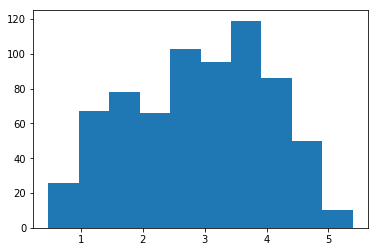

In [3]:
plt.hist(reg_params['y_info']);

In [18]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params['probs_alpha'][:] = 2.0

prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [5]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [6]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -41915.85540242
Iter 1: f = -42484.17710191
Iter 2: f = -43219.78577055
Iter 3: f = -43838.85129290
Iter 4: f = -43886.57479762
Iter 5: f = -44052.34069208
Iter 6: f = -44382.73696956
Iter 7: f = -44104.69190494
Iter 8: f = -44509.45273705
Iter 9: f = -44625.87735479
Iter 10: f = -43996.58083203
Iter 11: f = -44668.64713481
Iter 12: f = -44695.66035031
Iter 13: f = -44712.47980082
Iter 14: f = -44704.96239020
Iter 15: f = -44722.43780852
Iter 16: f = -44729.25743395
Iter 17: f = -44738.22951307
Iter 18: f = -44740.23999910
Iter 19: f = -44715.28449720
Iter 20: f = -44742.72565531
Iter 21: f = -44707.90892957
Iter 22: f = -44744.46733066
Iter 23: f = -44747.96115883
Iter 24: f = -44750.05369693
Iter 25: f = -44736.16173060
Iter 26: f = -44752.41920811
Iter 27: f = -44751.80468410
Iter 28: f = -44753.34979321
Iter 29: f = -44753.91065508
Iter 30: f = -44754.66391597
Iter 31: f = -44750.19384892
Iter 32: f = -44755.06718830
Iter 33: f = -44755.24087793
Iter 34: f = -44755.5281

In [7]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [8]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape

((238, 238), (238,))

In [9]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -44772.08375878
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -44772.08375878
Iter 2: f = -44772.08376027
1.4857141650281847e-06
Iter 3: f = -44772.08376027
Success.
  Running preconditioned optimization.
Iter 0: f = -44772.08376027
Iter 1: f = -44772.08376027
Iter 4: f = -44772.08376027
f_diff: 1.485728716943413e-06
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Taking Newton step.
  Converging with small Newton step.
Optimization time: 61.27571654319763 seconds


In [19]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = os.path.join(fit_dir, '{}.npz'.format(analysis_name))
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to /home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits/transformed_gene_regression_df4_degree3_genes700_num_components30_inflate1.0_shrunkTrue_fit.npz


In [14]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[ 2.00000648  2.95865061  4.00894069  5.94556982  6.02285509  8.00293717
  8.86990594  9.00646054  9.84068409  9.94819936 10.48046269 11.02217534
 12.49166318 13.31802122 13.92604562 15.97820637 18.65437122 21.21134773
 22.04608327 26.41959898 26.59793776 31.46224687 38.32495468 43.91983666
 45.43768567 46.86597092 48.68118858 53.91878265 56.12921056 76.51000023]


In [11]:
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

In [15]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))

small_cluster_size = 1.1

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < small_cluster_size))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
print('There are', len(small_clusters), 'small clusters')
k_small = 0
n_in_cluster = np.argwhere(obs_k == small_clusters[k_small])

if len(n_in_cluster) > 0:
    n = int(n_in_cluster[0])

    # Get the top alternative components
    top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[0:5]

    f, axarr = plt.subplots(1, figsize=(15,8))
    this_plot = axarr
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(60): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.04, linewidth=4);

    for k in top_components:
        if k != k_small:
            this_plot.plot(opt_gmm_params['centroids'][k, :],
                           color = 'lightblue', linewidth=2);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);
else:
    print('No points belong mostly to this cluster ({}).'.format(small_clusters[k_small]))


There are 0 small clusters


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()